FRE-6971 Final Part 2
5/14/2018 by Yidi Wang
Hope you enjoy my final project. :)

Problem 1

In [1]:
# import the packages I will use in the whole project.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.integrate as integrates
import scipy.optimize as opt
%matplotlib inline
# Work with the 'Constant_Maturity_ED/csv'
df = pd.read_csv('D:/FIproject/Constant_Maturity_ED.csv')
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

E:\Python\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Have a look at the data.
# df.head(5)

In [3]:
# According to the homework, seperate the historical samples.
# sample_A is the training sample, sample_B is the cross-validation sample, sample_C is the test sample.
sample_A = df[(df.index >= '2011-1-1') & (df.index <= '2015-1-1')]
sample_B = df[(df.index >= '2015-1-1') & (df.index <= '2016-1-1')]
sample_C = df[(df.index >= '2016-1-1') & (df.index <= '2017-1-1')]

Q1. Use Sample A to compute 5 cointegrated pairs of futures rates.
[2y,3y], [3y,4y], [4y,5y], [2y,4y], [3y,5y]
A1. (1) Work with PCA to decompose the covariance.
    (2) Get weights and compute the cointegrated pairs by neutraling the PCA loadings.

In [4]:
# (1) Work with PCA to decompose the covariance.
C = sample_A.cov()
evals, evecs = np.linalg.eig(C)
indices = np.argsort(evals)
indices = indices[::-1]
evecs = evecs[:,indices]
evals = evals[indices]
print('[PCA1,PCA2] of the data \n')
print(evecs[:, 0:2])

[PCA1,PCA2] of the data 

[[ 0.01436806 -0.00328403]
 [ 0.00645796 -0.0300627 ]
 [-0.00911671 -0.09049966]
 [-0.0343564  -0.16482596]
 [-0.06753391 -0.23176147]
 [-0.10459902 -0.28559017]
 [-0.14066126 -0.32029483]
 [-0.17390795 -0.32745644]
 [-0.20442648 -0.31019504]
 [-0.23150179 -0.27225741]
 [-0.25341959 -0.21839156]
 [-0.26942824 -0.15443087]
 [-0.2811778  -0.08326633]
 [-0.29039104 -0.00974894]
 [-0.29687537  0.06220231]
 [-0.30013811  0.13197947]
 [-0.30142782  0.20123446]
 [-0.30098001  0.26481245]
 [-0.29917954  0.31872668]
 [-0.29698286  0.36908474]]


In [5]:
# (2) Get weights and compute the cointegrated pairs.
# pairs of [2y,3y], [3y,4y], [4y,5y], [2y,4y], [3y,5y].
# [2y-w1*3y], [3y-w2*4y], [4y-w3*5y], [2y-w4*4y], [3y-w5*5y].
w = [evecs[7,0]/evecs[11,0], evecs[11,0]/evecs[15,0], evecs[15,0]/evecs[19,0],
     evecs[7,0]/evecs[15,0], evecs[11,0]/evecs[19,0]]
pair_1 = sample_A['ED8'] - w[0] * sample_A['ED12']
pair_2 = sample_A['ED12'] - w[1] * sample_A['ED16']
pair_3 = sample_A['ED16'] - w[2] * sample_A['ED20']
pair_4 = sample_A['ED8'] - w[3] * sample_A['ED16']
pair_5 = sample_A['ED12'] - w[4] * sample_A['ED20']

Q2. Construct the following:
    a. AR(1) model fitted to each of the 5 cointegrated vectors. (Signal 1)
    b. AR(1) model fitted to each {cointegrated vector - EMA(lambda)}. (Signal 2)
A2. For a and b, define functions about the specific type.

In [6]:
# a. Signal 1 constrcution.
#   AR(1): X(t) = a + b * X(t-1) + e(t)
#   Idea is use the data to fit the model and get the params.
def AR_1(data):
    data_lag = data.shift(1).dropna()
    df = data.drop(data.index[0]).dropna()
    X = data_lag.as_matrix()
    X_I = sm.add_constant(X)
    Y = df.as_matrix()
    l1 = sm.OLS(Y, X_I).fit()
    return l1

In [7]:
# Fit the AR(1) model.
fit_1 = AR_1(pair_1).params
fit_2 = AR_1(pair_2).params
fit_3 = AR_1(pair_3).params
fit_4 = AR_1(pair_4).params
fit_5 = AR_1(pair_5).params

print('AR(1) model is: \n')
print('AR(1) model of pair 1 is: Yt = %f + %f * Yt-1'%(fit_1[0], fit_1[1]))
print('AR(1) model of pair 2 is: Yt = %f + %f * Yt-1'%(fit_2[0], fit_2[1]))
print('AR(1) model of pair 3 is: Yt = %f + %f * Yt-1'%(fit_3[0], fit_3[1]))
print('AR(1) model of pair 4 is: Yt = %f + %f * Yt-1'%(fit_4[0], fit_4[1]))
print('AR(1) model of pair 5 is: Yt = %f + %f * Yt-1'%(fit_5[0], fit_5[1]))

AR(1) model is: 

AR(1) model of pair 1 is: Yt = -0.000920 + 0.984395 * Yt-1
AR(1) model of pair 2 is: Yt = -0.004417 + 0.989006 * Yt-1
AR(1) model of pair 3 is: Yt = -0.167634 + 0.725586 * Yt-1
AR(1) model of pair 4 is: Yt = -0.003653 + 0.988282 * Yt-1
AR(1) model of pair 5 is: Yt = -0.069021 + 0.929906 * Yt-1


In [8]:
# b. Signal 2 Construction.
#   Same AR(1) model as the above but different data.
#   First need to constrcut the {cointegrated vector - EMA(lambda)}.

In [9]:
# For EMA serie, type is: M(t) = lambda * S(t) + (1-lambda) * M(t-1).
def EMA_AR_1(lambda_, data):
    M = data.dropna()
    for i in range(1,len(M)):
        M[i] = (1 - lambda_)*M[i-1] + lambda_ * data[i]
    data_EMA = data - M
    # Use this model to fit the AR(1) model.
    return AR_1(data_EMA), data_EMA

Q3. Compute half-lives for all signals. Pick lambda to make sure that half-life Signal 2 is ~5days.
A3. (1) For Singal 1, just compute the HF1.
    (2) For Signal 2, use optimize to pick lambda make the HF2 to ~5days.

In [10]:
# (1) For Signal 1.
#     According to the definition, half-life is just the time takes to get the half of the initial value.
#     The equation is log(0.5)/log(b), for which b is from X(t) = a + b * X(t-1) + e(t).
def HF(b):
    hf = math.log(0.5)/math.log(b)
    return hf

In [11]:
print('Half Life for Signal 1: \n')
print('Half-life of pair 1 is %f days'%(HF(fit_1[1])))
print('Half-life of pair 2 is %f days'%(HF(fit_2[1])))
print('Half-life of pair 3 is %f days'%(HF(fit_3[1])))
print('Half-life of pair 4 is %f days'%(HF(fit_4[1])))
print('Half-life of pair 5 is %f days'%(HF(fit_5[1])))

Half Life for Signal 1: 

Half-life of pair 1 is 44.070088 days
Half-life of pair 2 is 62.703103 days
Half-life of pair 3 is 2.160844 days
Half-life of pair 4 is 58.807299 days
Half-life of pair 5 is 9.538006 days


In [12]:
# (2) For Signal 2.
#     Choose lambda to make the Half Life of Signal 2 is ~5days.
#     Work with optimize function.
def error(lambda_, data):
    EMA_fit = EMA_AR_1(lambda_, data)[0].params
    hf = HF(EMA_fit[1])
    error = abs(hf - 5)
    return error

In [13]:
# Set the initial value of lambda to optimize.
initial_lambda = 0.1
lambda_1 = opt.leastsq(error, initial_lambda, args = pair_1)[0]
lambda_2 = opt.leastsq(error, initial_lambda, args = pair_2)[0]
lambda_3 = opt.leastsq(error, initial_lambda, args = pair_3)[0]
lambda_4 = opt.leastsq(error, initial_lambda, args = pair_4)[0]
lambda_5 = opt.leastsq(error, initial_lambda, args = pair_5)[0]

E:\Python\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
E:\Python\lib\site-packages\numpy\linalg\linalg.py:1574: RuntimeWarning: invalid value encountered in greater
  return (S > tol).sum(axis=-1)


In [14]:
print('Opitimized lambda for each EMA paris: \n')
print('lambda_1 for Half-Life ~5days of EMA_1 = %f'%(lambda_1))
print('lambda_2 for Half-Life ~5days of EMA_2 = %f'%(lambda_2))
print('lambda_3 for Half-Life ~5days of EMA_3 = %f'%(lambda_3))
print('lambda_4 for Half-Life ~5days of EMA_4 = %f'%(lambda_4))
print('lambda_5 for Half-Life ~5days of EMA_5 = %f'%(lambda_5))

Opitimized lambda for each EMA paris: 

lambda_1 for Half-Life ~5days of EMA_1 = 0.049055
lambda_2 for Half-Life ~5days of EMA_2 = 0.053806
lambda_3 for Half-Life ~5days of EMA_3 = -0.005792
lambda_4 for Half-Life ~5days of EMA_4 = 0.054425
lambda_5 for Half-Life ~5days of EMA_5 = 0.008287


In [15]:
fit_EMA1 = EMA_AR_1(lambda_1,pair_1)[0].params
fit_EMA2 = EMA_AR_1(lambda_2,pair_2)[0].params
fit_EMA3 = EMA_AR_1(lambda_3,pair_3)[0].params
fit_EMA4 = EMA_AR_1(lambda_4,pair_4)[0].params
fit_EMA5 = EMA_AR_1(lambda_5,pair_5)[0].params

Q4. Signal 3 is a gussian mixture of signals 1&2.
    Weight of the mixture, theta, is a free parameter you can try to determine using Cross-Validation   Sample B.

In [16]:
# Choose theta 0.5, which is a equally combined of Signal 1 & 2.
theta = [0.5, 0.5, 0.5, 0.5, 0.5]
mix_1 = theta[0] * AR_1(pair_1).fittedvalues + (1-theta[0]) * EMA_AR_1(lambda_1,pair_1)[0].fittedvalues
mix_2 = theta[1] * AR_1(pair_2).fittedvalues + (1-theta[1]) * EMA_AR_1(lambda_2,pair_2)[0].fittedvalues
mix_3 = theta[2] * AR_1(pair_3).fittedvalues + (1-theta[2]) * EMA_AR_1(lambda_3,pair_3)[0].fittedvalues
mix_4 = theta[3] * AR_1(pair_4).fittedvalues + (1-theta[3]) * EMA_AR_1(lambda_4,pair_4)[0].fittedvalues
mix_5 = theta[4] * AR_1(pair_5).fittedvalues + (1-theta[4]) * EMA_AR_1(lambda_5,pair_5)[0].fittedvalues

Q5. Define a set of signal quality metrics, and use Cross-Validation Sample B to choose theta that is maximizing the quality of signal metrics you chose. For simplicity, we will use all the AR(1) estimations from the Training Sample A.

In [17]:
# a. Signal quanlity metrics will measure correlation between a forecast, E[z(t+H)|t], 
#    and realized z(t+H) for Signals 1,2,3 and all cointegrated pairs z(t).
# First, use the weight to construct the sample data.
pair_B1 = sample_B['ED8'] - w[0] * sample_B['ED12']
pair_B2 = sample_B['ED12'] - w[1] * sample_B['ED16']
pair_B3 = sample_B['ED16'] - w[2] * sample_B['ED20']
pair_B4 = sample_B['ED8'] - w[3] * sample_B['ED16']
pair_B5 = sample_B['ED12'] - w[4] * sample_B['ED20']

In [18]:
# b. H=Horizon, use H = 10 days.
def forecast(h, fit, data):
    forecast = data
    for i in range(h):
        # According to the AR(1) model assumption.
        forecast = fit[0] + fit[1] * forecast
    return forecast
# For the 3 signals of 5 pairs.
# Pair 1 [2y,3y].
signal1_forecast_1 = forecast(10, fit_1, pair_B1)
signal2_forecast_1 = forecast(10, fit_EMA1, pair_B1)
signal3_forecast_1 = theta[0] * signal1_forecast_1 + (1-theta[0]) * signal2_forecast_1

# Pair 2 [3y,4y].
signal1_forecast_2 = forecast(10, fit_1, pair_B2)
signal2_forecast_2 = forecast(10, fit_EMA1, pair_B2)
signal3_forecast_2 = theta[0] * signal1_forecast_2 + (1-theta[0]) * signal2_forecast_2

# Pair 3 [3y,4y].
signal1_forecast_3 = forecast(10, fit_1, pair_B3)
signal2_forecast_3 = forecast(10, fit_EMA1, pair_B3)
signal3_forecast_3 = theta[0] * signal1_forecast_3 + (1-theta[0]) * signal2_forecast_3

# Pair 4 [2y,4y].
signal1_forecast_4 = forecast(10, fit_1, pair_B1)
signal2_forecast_4 = forecast(10, fit_EMA1, pair_B1)
signal3_forecast_4 = theta[0] * signal1_forecast_4 + (1-theta[0]) * signal2_forecast_4

# Pair 5 [3y,5y].
signal1_forecast_5 = forecast(10, fit_1, pair_B1)
signal2_forecast_5 = forecast(10, fit_EMA1, pair_B1)
signal3_forecast_5 = theta[0] * signal1_forecast_5 + (1-theta[0]) * signal2_forecast_5

In [19]:
# Subset the trading signals about the forecast outcome.
signal3_1 = signal3_forecast_1[:(len(signal3_forecast_1)-10)]
signal3_2 = signal3_forecast_2[:(len(signal3_forecast_1)-10)]
signal3_3 = signal3_forecast_3[:(len(signal3_forecast_1)-10)]
signal3_4 = signal3_forecast_4[:(len(signal3_forecast_1)-10)]
signal3_5 = signal3_forecast_5[:(len(signal3_forecast_1)-10)]

In [20]:
# c. Implement at least 2 different metrics.
# (1) Total return according to the signals, which is E(x(t+H)|t)-x(t).
# (2) The volatility of signals.
# d. alpha(t) = E[z(t+H)|t]-z(t), only consider |alpha(t)|>0.1 in your quality assignment.
alpha_1 = signal3_1 - pair_B1[:(len(pair_B1)-10)]
alpha_2 = signal3_2 - pair_B2[:(len(pair_B2)-10)]
alpha_3 = signal3_3 - pair_B3[:(len(pair_B3)-10)]
alpha_4 = signal3_4 - pair_B4[:(len(pair_B4)-10)]
alpha_5 = signal3_5 - pair_B5[:(len(pair_B5)-10)]

In [21]:
# Calculate the total return.
def return_cal(alpha):
    total_return = []
    for i in range(len(alpha)):
        if abs(alpha[i]) > 0.1:
            total_return.append(abs(alpha[i]))
    return total_return
total_1 = return_cal(alpha_1)
total_2 = return_cal(alpha_2)
total_3 = return_cal(alpha_3)
total_4 = return_cal(alpha_4)
total_5 = return_cal(alpha_5)

In [22]:
# Use cross-validation to find the optimize theta.
# First, define the optimize function.
def total_return(theta, fit, fit_EMA, data):
    signal1_forecast = forecast(10, fit, data)
    signal2_forecast = forecast(10, fit_EMA, data)
    signal3_forecast = theta * signal1_forecast + (1-theta) * signal2_forecast
    signal3 = signal3_forecast[:(len(signal3_forecast)-10)]
    alpha = signal3 - data[:(len(data)-10)]
    total_return = return_cal(alpha)
    return -np.sum(total_return)

In [23]:
# Second, do optimization process.
theta_ini = 0.5
theta_1 = opt.least_squares(total_return, theta_ini, args = (fit_1,fit_EMA1,pair_B1),bounds=(0,1)).x
theta_2 = opt.least_squares(total_return, theta_ini, args = (fit_2,fit_EMA2,pair_B2),bounds=(0,1)).x
theta_3 = opt.least_squares(total_return, theta_ini, args = (fit_3,fit_EMA3,pair_B3),bounds=(0,1)).x
theta_4 = opt.least_squares(total_return, theta_ini, args = (fit_4,fit_EMA4,pair_B4),bounds=(0,1)).x
theta_5 = opt.least_squares(total_return, theta_ini, args = (fit_5,fit_EMA5,pair_B5),bounds=(0,1)).x

In [24]:
print('The optimal theta \n')
print('The optimal theta1 is: %f'%(theta_1))
print('The optimal theta2 is: %f'%(theta_2))
print('The optimal theta3 is: %f'%(theta_3))
print('The optimal theta4 is: %f'%(theta_4))
print('The optimal theta5 is: %f'%(theta_5))

The optimal theta 

The optimal theta1 is: 0.946283
The optimal theta2 is: 0.500000
The optimal theta3 is: 0.469042
The optimal theta4 is: 0.962151
The optimal theta5 is: 0.482462


Q6. Run your signal quality analysis using a testing sample C. Beak the test sample into 4 quarters, 
and see how your results evolve from quarter to quarter. Analyze the results.

In [25]:
pair_C1 = sample_C['ED8'] - w[0] * sample_C['ED12']
pair_C2 = sample_C['ED12'] - w[1] * sample_C['ED16']
pair_C3 = sample_C['ED16'] - w[2] * sample_C['ED20']
pair_C4 = sample_C['ED8'] - w[3] * sample_C['ED16']
pair_C5 = sample_C['ED12'] - w[4] * sample_C['ED20']

In [26]:
test_1 = theta_1 * AR_1(pair_C1).fittedvalues + (1-theta_1) * EMA_AR_1(lambda_1,pair_C1)[0].fittedvalues
test_2 = theta_2 * AR_1(pair_C2).fittedvalues + (1-theta_2) * EMA_AR_1(lambda_2,pair_C2)[0].fittedvalues
test_3 = theta_3 * AR_1(pair_C3).fittedvalues + (1-theta_3) * EMA_AR_1(lambda_3,pair_C3)[0].fittedvalues
test_4 = theta_4 * AR_1(pair_C4).fittedvalues + (1-theta_4) * EMA_AR_1(lambda_4,pair_C4)[0].fittedvalues
test_5 = theta_5 * AR_1(pair_C5).fittedvalues + (1-theta_5) * EMA_AR_1(lambda_5,pair_C5)[0].fittedvalues

Q6. Run your signal quality analysis using a testing sample C. Back the test sample into 4 quarters, 
and see how your results evolve from quareter to quarter. Analyze all results.

Text(0.5,1,'Test for the mixed signal.')

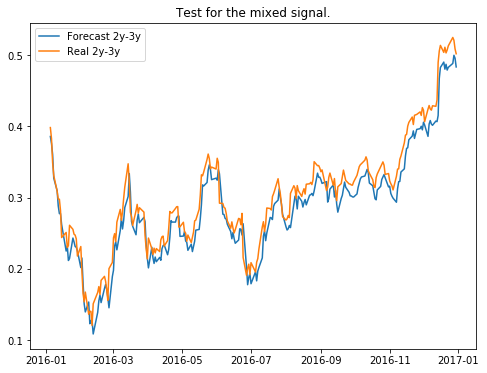

In [27]:
pair_C1_adjust = pair_C1.drop(pair_C1.index[0])
pd_test_1 = pd.DataFrame(test_1, index = pair_C1_adjust.index)
plt.figure(figsize=(8,6))
plt.plot(pd_test_1, label = 'Forecast 2y-3y')
plt.plot(pair_C1_adjust, label = 'Real 2y-3y')
plt.legend(loc='best')
plt.title('Test for the mixed signal.')

Text(0.5,1,'Test for the mixed signal.')

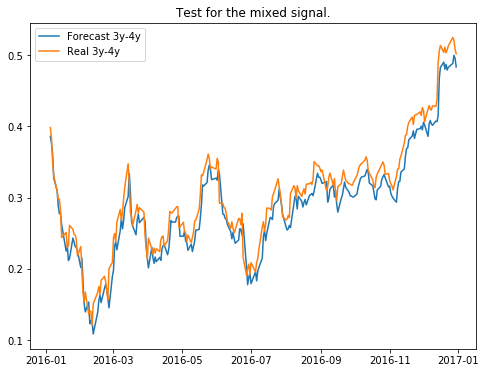

In [28]:
pair_C2_adjust = pair_C2.drop(pair_C2.index[0])
pd_test_2 = pd.DataFrame(test_2, index = pair_C2_adjust.index)
plt.figure(figsize=(8,6))
plt.plot(pd_test_1, label = 'Forecast 3y-4y')
plt.plot(pair_C1_adjust, label = 'Real 3y-4y')
plt.legend(loc='best')
plt.title('Test for the mixed signal.')

Text(0.5,1,'Test for the mixed signal.')

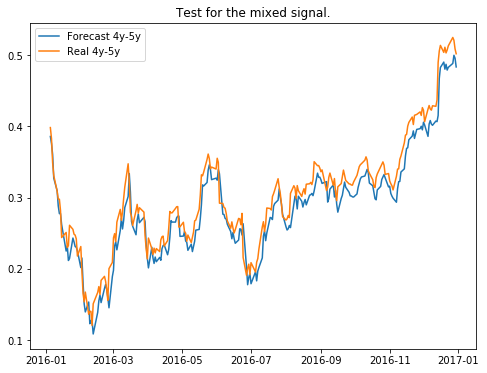

In [29]:
pair_C3_adjust = pair_C3.drop(pair_C3.index[0])
pd_test_3 = pd.DataFrame(test_3, index = pair_C3_adjust.index)
plt.figure(figsize=(8,6))
plt.plot(pd_test_1, label = 'Forecast 4y-5y')
plt.plot(pair_C1_adjust, label = 'Real 4y-5y')
plt.legend(loc='best')
plt.title('Test for the mixed signal.')

Text(0.5,1,'Test for the mixed signal.')

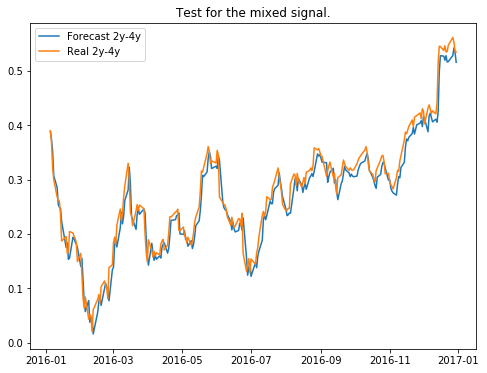

In [30]:
pair_C4_adjust = pair_C4.drop(pair_C4.index[0])
pd_test_4 = pd.DataFrame(test_4, index = pair_C4_adjust.index)
plt.figure(figsize=(8,6))
plt.plot(pd_test_4, label = 'Forecast 2y-4y')
plt.plot(pair_C4_adjust, label = 'Real 2y-4y')
plt.legend(loc='best')
plt.title('Test for the mixed signal.')

Text(0.5,1,'Test for the mixed signal.')

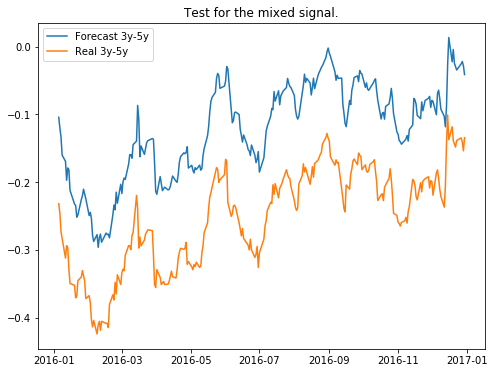

In [31]:
pair_C5_adjust = pair_C5.drop(pair_C5.index[0])
pd_test_5 = pd.DataFrame(test_5, index = pair_C5_adjust.index)
plt.figure(figsize=(8,6))
plt.plot(pd_test_5, label = 'Forecast 3y-5y')
plt.plot(pair_C5_adjust, label = 'Real 3y-5y')
plt.legend(loc='best')
plt.title('Test for the mixed signal.')

In [32]:
perform_1 = pd_test_1[0]-pair_C1_adjust
analysis1_q1 = perform_1[(perform_1.index >= '2016-01-01') & (perform_1.index <= '2016-03-31')]
analysis1_q2 = perform_1[(perform_1.index >= '2016-04-01') & (perform_1.index <= '2016-05-31')]
analysis1_q3 = perform_1[(perform_1.index >= '2016-06-01') & (perform_1.index <= '2016-08-31')]
analysis1_q4 = perform_1[(perform_1.index >= '2016-09-01') & (perform_1.index <= '2017-01-31')]

In [33]:
print('The signal quality analysis for [2y,3y]: \n')
print('Quarter 1:The sum of error is %f and the standard error is %f.'%(abs(analysis1_q1).sum(), analysis1_q1.std()))
print('Quarter 2:The sum of error is %f and the standard error is %f.'%(abs(analysis1_q2).sum(), analysis1_q2.std()))
print('Quarter 3:The sum of error is %f and the standard error is %f.'%(abs(analysis1_q3).sum(), analysis1_q3.std()))
print('Quarter 4:The sum of error is %f and the standard error is %f.'%(abs(analysis1_q4).sum(), analysis1_q4.std()))

The signal quality analysis for [2y,3y]: 

Quarter 1:The sum of error is 1.039012 and the standard error is 0.018756.
Quarter 2:The sum of error is 0.718655 and the standard error is 0.012212.
Quarter 3:The sum of error is 1.147360 and the standard error is 0.015851.
Quarter 4:The sum of error is 1.769825 and the standard error is 0.011458.


In [34]:
perform_2 = pd_test_2[0]-pair_C2_adjust
analysis2_q1 = perform_2[(perform_2.index >= '2016-01-01') & (perform_2.index <= '2016-03-31')]
analysis2_q2 = perform_2[(perform_2.index >= '2016-04-01') & (perform_2.index <= '2016-05-31')]
analysis2_q3 = perform_2[(perform_2.index >= '2016-06-01') & (perform_2.index <= '2016-08-31')]
analysis2_q4 = perform_2[(perform_2.index >= '2016-09-01') & (perform_2.index <= '2017-01-31')]
print('The signal quality analysis for [3y,4y]: \n')
print('Quarter 1:The sum of error is %f and the standard error is %f.'%(abs(analysis2_q1).sum(), analysis2_q1.std()))
print('Quarter 2:The sum of error is %f and the standard error is %f.'%(abs(analysis2_q2).sum(), analysis2_q2.std()))
print('Quarter 3:The sum of error is %f and the standard error is %f.'%(abs(analysis2_q3).sum(), analysis2_q3.std()))
print('Quarter 4:The sum of error is %f and the standard error is %f.'%(abs(analysis2_q4).sum(), analysis2_q4.std()))

The signal quality analysis for [3y,4y]: 

Quarter 1:The sum of error is 2.135918 and the standard error is 0.014898.
Quarter 2:The sum of error is 1.554031 and the standard error is 0.008046.
Quarter 3:The sum of error is 1.463543 and the standard error is 0.010819.
Quarter 4:The sum of error is 0.721100 and the standard error is 0.009540.


In [35]:
perform_3 = pd_test_3[0]-pair_C3_adjust
analysis3_q1 = perform_3[(perform_3.index >= '2016-01-01') & (perform_3.index <= '2016-03-31')]
analysis3_q2 = perform_3[(perform_3.index >= '2016-04-01') & (perform_3.index <= '2016-05-31')]
analysis3_q3 = perform_3[(perform_3.index >= '2016-06-01') & (perform_3.index <= '2016-08-31')]
analysis3_q4 = perform_3[(perform_3.index >= '2016-09-01') & (perform_3.index <= '2017-01-31')]
print('The signal quality analysis for [4y,5y]: \n')
print('Quarter 1:The sum of error is %f and the standard error is %f.'%(abs(analysis3_q1).sum(), analysis3_q1.std()))
print('Quarter 2:The sum of error is %f and the standard error is %f.'%(abs(analysis3_q2).sum(), analysis3_q2.std()))
print('Quarter 3:The sum of error is %f and the standard error is %f.'%(abs(analysis3_q3).sum(), analysis3_q3.std()))
print('Quarter 4:The sum of error is %f and the standard error is %f.'%(abs(analysis3_q4).sum(), analysis3_q4.std()))

The signal quality analysis for [4y,5y]: 

Quarter 1:The sum of error is 7.306526 and the standard error is 0.011935.
Quarter 2:The sum of error is 4.639989 and the standard error is 0.007156.
Quarter 3:The sum of error is 6.954241 and the standard error is 0.009469.
Quarter 4:The sum of error is 9.094620 and the standard error is 0.011062.


In [36]:
perform_4 = pd_test_4[0]-pair_C4_adjust
analysis4_q1 = perform_4[(perform_4.index >= '2016-01-01') & (perform_4.index <= '2016-03-31')]
analysis4_q2 = perform_4[(perform_4.index >= '2016-04-01') & (perform_4.index <= '2016-05-31')]
analysis4_q3 = perform_4[(perform_4.index >= '2016-06-01') & (perform_4.index <= '2016-08-31')]
analysis4_q4 = perform_4[(perform_4.index >= '2016-09-01') & (perform_4.index <= '2017-01-31')]
print('The signal quality analysis for [4y,5y]: \n')
print('Quarter 1:The sum of error is %f and the standard error is %f.'%(abs(analysis4_q1).sum(), analysis4_q1.std()))
print('Quarter 2:The sum of error is %f and the standard error is %f.'%(abs(analysis4_q2).sum(), analysis4_q2.std()))
print('Quarter 3:The sum of error is %f and the standard error is %f.'%(abs(analysis4_q3).sum(), analysis4_q3.std()))
print('Quarter 4:The sum of error is %f and the standard error is %f.'%(abs(analysis4_q4).sum(), analysis4_q4.std()))

The signal quality analysis for [4y,5y]: 

Quarter 1:The sum of error is 1.241632 and the standard error is 0.025329.
Quarter 2:The sum of error is 0.679041 and the standard error is 0.016406.
Quarter 3:The sum of error is 1.099240 and the standard error is 0.020854.
Quarter 4:The sum of error is 1.474258 and the standard error is 0.015746.


In [37]:
perform_5 = pd_test_5[0]-pair_C5_adjust
analysis5_q1 = perform_5[(perform_5.index >= '2016-01-01') & (perform_5.index <= '2016-03-31')]
analysis5_q2 = perform_5[(perform_5.index >= '2016-04-01') & (perform_5.index <= '2016-05-31')]
analysis5_q3 = perform_5[(perform_5.index >= '2016-06-01') & (perform_5.index <= '2016-08-31')]
analysis5_q4 = perform_5[(perform_5.index >= '2016-09-01') & (perform_5.index <= '2017-01-31')]
print('The signal quality analysis for [4y,5y]: \n')
print('Quarter 1:The sum of error is %f and the standard error is %f.'%(abs(analysis5_q1).sum(), analysis5_q1.std()))
print('Quarter 2:The sum of error is %f and the standard error is %f.'%(abs(analysis5_q2).sum(), analysis5_q2.std()))
print('Quarter 3:The sum of error is %f and the standard error is %f.'%(abs(analysis5_q3).sum(), analysis5_q3.std()))
print('Quarter 4:The sum of error is %f and the standard error is %f.'%(abs(analysis5_q4).sum(), analysis5_q4.std()))

The signal quality analysis for [4y,5y]: 

Quarter 1:The sum of error is 7.791490 and the standard error is 0.019136.
Quarter 2:The sum of error is 5.754577 and the standard error is 0.011163.
Quarter 3:The sum of error is 8.762979 and the standard error is 0.016268.
Quarter 4:The sum of error is 10.086493 and the standard error is 0.017944.


Q6 Analysis.
For portfolio 1, the overall fitting is pretty good and the 2nd quarter is the best.
For portfolio 2, the overall fitting well good and the 4th quarter is the best.
For portfolio 3, the overall fitting is not that good.
For portfolio 4, the overall fitting is pretty good and the 2nd quarter is the best.
For portfolio 5, the overall fitting is not that good.

All Results Analysis: 
During the project, I actually finish several consecutive parts.
First, I use the PCA decomposition to generate 5 pairs of EuroDollar Futures portfolio.
Second, based on the pairs, I generate two signals AR(1) and AR(1)-EMA(lambda_).
Third, I use the half-life constrains to optimize the lambda_.
Fourth, I generate a Gaussian mixture of this two signals with parameter theta.
Then use the cross-validation sample B to get the optimal theta
Fifth, I use the optimal theta to do forecast about the test data.
After generating the forecast, I do the error analysis.